In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
# Using Movie lens 100K dataset
df = pd.read_csv('ratings.csv')

In [3]:
df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


## Pre-Processing the data:

In [4]:
#limiting the movieId to less than 500 to reduce the data size for the system to process easily. 
df = df[df['movieId'] <= 500]

# choose movies with ratings greater than 4.5 because each user-movie interaction irrespective of the rating is considered as the movie was liked by that user for VAE 
df = df[df['rating'] >= 4.5]

In [5]:
# choose only users who have intereacted with atlest 10 movies.
d = dict(Counter(list(df['userId'])))
validUsers = []
for i in d.keys():
    if(d[i] >= 10):
        validUsers.append(i)
len(validUsers)

94

In [6]:
df = df.loc[df['userId'].isin(validUsers)]

In [7]:
user_ids = df["userId"].unique().tolist()

In [8]:
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

In [9]:
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

In [10]:
df 
# userID and movieId which has missing values due to preprocessing, is encoded into new IDs stored in 'user' and 'movie' column.

,userId,movieId,rating,timestamp,user,movie
148,4,34,5.0,949919556,0,0
149,4,112,5.0,949810582,0,1
150,4,141,5.0,949919681,0,2
154,4,260,5.0,949779042,0,3
156,4,296,5.0,949895708,0,4
...,...,...,...,...,...,...
98451,659,300,5.0,834598140,93,51
98460,659,339,5.0,834999161,93,119
98467,659,364,5.0,834598537,93,8
98475,659,380,5.0,834598040,93,69


In [11]:
num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 94, Number of Movies: 266, Min rating: 4.5, Max rating: 5.0


#### Creating user-movie interaction matrix:

In [12]:
interactions = np.zeros((num_users,num_movies), dtype=float)

In [13]:
for ind in df.index:
    interactions[df['user'][ind]][df['movie'][ind]] = 1

In [14]:
np.shape(interactions)

(94, 266)

In [15]:
l_interactions = [[[0.] for i in range(266)] for j in range(94)]
for ind in df.index:
    l_interactions[df['user'][ind]][df['movie'][ind]] = [1.0]
    #print(interactions[df['user'][ind]][df['movie'][ind]+1])

l_interactions = [l_interactions]*1000
train_interactions = l_interactions [:800]
test_interactions = l_interactions [800:]

train_interactions = np.array(train_interactions)
test_interactions = np.array(test_interactions)

# EASE Model:

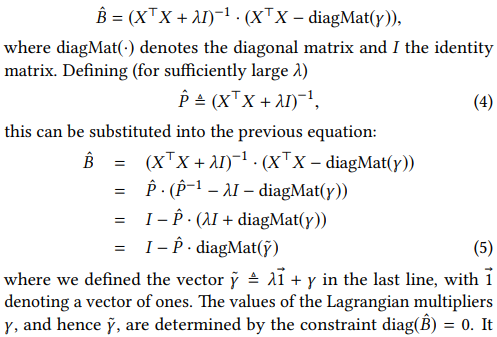
##### after solving the lagrangian eq., we get: 

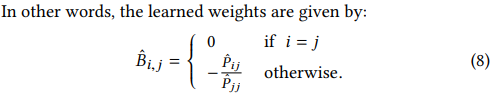

In [17]:
class EASE:
    
    def fit(self, df,interactions, Lambda: float = 0.5):
        """
        df: Dataset with user_id, item_id and rating.
        lambda: Ridge-regularization parameter.
        """
        X = csr_matrix(interactions)     # csr_matrix used to store sparse matrix    
        self.X = X
        #print(X)
        G = X.T.dot(X).toarray()  # Gram Matrix G = X.t() * X    # item-item matrix
        diagIndices = np.diag_indices(G.shape[0]) 
        G[diagIndices] += Lambda 
        P = np.linalg.inv(G)
        B = P / (-np.diag(P)) # Weight Matrix
        B[diagIndices] = 0

        self.B = B
        self.pred = X.dot(B)
        # Prediction P(user, item) = X[user] * B[item]

    def predictUsingVAE(self, users, items, k, watched=None):
        for user in users:
            if watched:
                exclude_set = set(train.loc[train['user_id'] == user, 'item_id'])
                candidates = [item for item in items if item not in exclude_set]
            else:
                candidates=items
            pred = np.take(self.pred[user, :], candidates)
            res = np.argsort(pred)[::-1][:k]
            print("Top",k,"preditions for user",user," and their user-movie ratings are:")
            UI_ratings = [round(rat,4) for rat in np.take(pred, res)]
            pred_rating_list = zip(np.take(candidates, res),UI_ratings)
            for i in pred_rating_list:
                print(i)
    def getXB(self):
        return self.pred

In [26]:
EASE_op = ease.getXB()

In [27]:
np.shape(EASE_op)

(94, 266)

In [28]:
# Matrix X_cap obtained from EASE model
EASE_op

array([[ 8.60649724e-01,  8.05073811e-01,  8.79996845e-01, ...,
        -7.19499106e-03, -1.02883021e-02, -1.02883021e-02],
       [ 6.74361226e-03,  1.79258847e-03, -1.38699799e-03, ...,
        -7.40677399e-03,  1.10920678e-03,  1.10920678e-03],
       [-9.47244106e-03, -1.62478179e-02,  2.31178609e-02, ...,
         8.81205649e-03,  9.62229690e-03,  9.62229690e-03],
       ...,
       [ 8.85425553e-01, -1.01544101e-02,  6.83017410e-02, ...,
         3.05106018e-03,  1.97957048e-03,  1.97957048e-03],
       [ 9.72553431e-01, -9.46933333e-03,  4.51709449e-04, ...,
         1.35417624e-03,  9.39949867e-01,  9.39949867e-01],
       [-2.54962086e-02,  1.24135731e-03, -1.29275312e-02, ...,
         2.87552501e-03,  4.92025803e-03,  4.92025803e-03]])

# VAE:

In [29]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        print(batch, dim)
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim), mean=0., stddev=1.)
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [30]:
# Encoder Model with sampling

latent_dim = 25
batch_size = 1
original_dim = (94,266,1)
h = 50
encoder_inputs = keras.Input(shape=(94,266,1))
x = layers.Flatten()(encoder_inputs)
#x = layers.Dense(h, activation="relu")(encoder_inputs)
x = layers.Dense(h,activation="relu")(x)
x = layers.LayerNormalization()(x)
x = layers.Dense(h, activation="relu")(x)
x = layers.LayerNormalization()(x)
x = layers.Dense(h, activation="relu")(x)
x = layers.LayerNormalization()(x)
x = layers.Dense(h, activation="relu")(x)
x = layers.LayerNormalization()(x)
x = layers.Dense(h, activation="relu")(x)
x = layers.LayerNormalization()(x)
x = layers.Dense(h, activation="relu")(x)
x = layers.LayerNormalization()(x)
x = layers.Dense(h, activation="relu")(x)
x = layers.LayerNormalization()(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Tensor("sampling/strided_slice:0", shape=(), dtype=int32) Tensor("sampling/strided_slice_1:0", shape=(), dtype=int32)
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 94, 266, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 flatten (Flatten)              (None, 25004)        0           ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 50)           1250250     ['flatten[0][0]']                
                                                                         

In [31]:
# Decoder Model

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(h,activation="relu")(latent_inputs)
x = layers.LayerNormalization()(x)
x = layers.Dense(h, activation="relu")(x)
x = layers.LayerNormalization()(x)
x = layers.Dense(h, activation="relu")(x)
x = layers.LayerNormalization()(x)
x = layers.Dense(h, activation="relu")(x)
x = layers.LayerNormalization()(x)
x = layers.Dense(94*266, activation="sigmoid")(x)
decoder_outputs = layers.Reshape((94, 266,1))(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 25)]              0         
                                                                 
 dense_7 (Dense)             (None, 50)                1300      
                                                                 
 layer_normalization_7 (Laye  (None, 50)               100       
 rNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 50)                2550      
                                                                 
 layer_normalization_8 (Laye  (None, 50)               100       
 rNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 50)                2550

In [32]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [33]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [34]:
vae.fit(train_interactions, epochs=30, batch_size=64)

Epoch 1/30
Tensor("encoder/sampling/strided_slice:0", shape=(), dtype=int32) Tensor("encoder/sampling/strided_slice_1:0", shape=(), dtype=int32)
Tensor("encoder/sampling/strided_slice:0", shape=(), dtype=int32) Tensor("encoder/sampling/strided_slice_1:0", shape=(), dtype=int32)
13/13 [==============================] - 8s 119ms/step - loss: 16472.4623 - reconstruction_loss: 15311.9395 - kl_loss: 32.5537
Epoch 2/30
13/13 [==============================] - 1s 114ms/step - loss: 10572.4506 - reconstruction_loss: 9376.6104 - kl_loss: 35.5667
Epoch 3/30
13/13 [==============================] - 2s 120ms/step - loss: 5968.5449 - reconstruction_loss: 5272.6045 - kl_loss: 37.0474
Epoch 4/30
13/13 [==============================] - 2s 145ms/step - loss: 3449.5264 - reconstruction_loss: 3082.7654 - kl_loss: 28.7744
Epoch 5/30
13/13 [==============================] - 2s 151ms/step - loss: 2160.6170 - reconstruction_loss: 1962.5236 - kl_loss: 22.4464
Epoch 6/30
13/13 [==============================]

In [35]:
Z_mean,Z_var,encoder_output = vae.encoder.predict(test_interactions)

Tensor("encoder/sampling/strided_slice:0", shape=(), dtype=int32) Tensor("encoder/sampling/strided_slice_1:0", shape=(), dtype=int32)


In [36]:
decoder_op = vae.decoder.predict(encoder_output)

In [37]:
# x_hat output obtained from VAE
print(decoder_op[0])

[[[0.9973583 ]
  [0.99745345]
  [0.99739456]
  ...
  [0.00251538]
  [0.00259602]
  [0.00268501]]

 [[0.0025903 ]
  [0.00246957]
  [0.00269395]
  ...
  [0.00247973]
  [0.00273713]
  [0.00255924]]

 [[0.00239146]
  [0.00246084]
  [0.00260991]
  ...
  [0.0025647 ]
  [0.00262904]
  [0.00248522]]

 ...

 [[0.9975449 ]
  [0.00272965]
  [0.00252059]
  ...
  [0.00240859]
  [0.00238767]
  [0.00256118]]

 [[0.9973837 ]
  [0.00266689]
  [0.00260186]
  ...
  [0.00265571]
  [0.9973542 ]
  [0.9973943 ]]

 [[0.00266665]
  [0.00243083]
  [0.00239906]
  ...
  [0.00266209]
  [0.00262743]
  [0.00251532]]]


In [38]:
l = [[] for i in range(94)]
for i in range(94):
    for j in range(266):
        l[i].append(decoder_op[0][i][j][0])

In [39]:
op_vae = np.array(l)

In [40]:
op_vae.shape

(94, 266)

# Hadamard Product of EASE and VAE outputs: 

In [41]:
vasp_output = np.multiply(op_vae,EASE_op)

In [42]:
vasp_output # X_hat obtained after hadamard product.

array([[ 8.58376164e-01,  8.03023651e-01,  8.77704067e-01, ...,
        -1.80981051e-05, -2.67086453e-05, -2.76241986e-05],
       [ 1.74679697e-05,  4.42692172e-06, -3.73650480e-06, ...,
        -1.83668148e-05,  3.03604836e-06,  2.83873150e-06],
       [-2.26529408e-05, -3.99832374e-05,  6.03355036e-05, ...,
         2.26002677e-05,  2.52974195e-05,  2.39134830e-05],
       ...,
       [ 8.83251731e-01, -2.77180293e-05,  1.72160755e-04, ...,
         7.34876491e-06,  4.72656632e-06,  5.07003986e-06],
       [ 9.70008952e-01, -2.52536762e-05,  1.17528563e-06, ...,
         3.59630580e-06,  9.37462957e-01,  9.37500662e-01],
       [-6.79895207e-05,  3.01752416e-06, -3.10138861e-05, ...,
         7.65491341e-06,  1.29276451e-05,  1.23760038e-05]])

In [47]:
def final_pred(vasp_op, users, items, k):
        for user in users:
            candidates=items
            pred = np.take(vasp_op[user, :], candidates)
            res = np.argsort(pred)[::-1][:k]
            print("Top",k," movie predictions for user",user,"")
            UI_ratings = [round(rat,5) for rat in np.take(pred, res)]
            pred_rating_list = np.take(candidates, res)
            for i in pred_rating_list:
                print(i)

In [48]:
# final_pred(vasp_output, list of users , list of movies to predict from [movieIDs], top-k )
# final_pred( [userIDs], [movieIDs], k)
final_pred(vasp_output,[0,3,44,93],[1,265,20,132,112],5)
#output - MovieIDs .

Top 5  movie preditions for user 0 
1
112
20
265
132
Top 5  movie preditions for user 3 
20
112
132
265
1
Top 5  movie preditions for user 44 
112
265
1
20
132
Top 5  movie preditions for user 93 
112
265
1
20
132
